# Prevendo a nota da prova final de alunos
Grupo:
- Ariel Tamezgui Leventhal
- André Barboza de Braga Melo
- Victoria Leal Garcia de Souza
- Rodrigo Anciães Patelli

## Introdução
Durante os últimos anos, com a vinda da pandemia e a mudança do ensino presencial para a modalidade online/à distância, houve [uma queda notável](https://www.nytimes.com/2021/06/23/us/failing-grades-covid.html) nas notas dos alunos que tiveram que se adaptar para um novo modelo de ensino. Sendo causada a queda pelo [efeito psicológico da pandemia](https://namica.org/blog/impact-on-the-mental-health-of-students-during-covid-19/), ou pela falta de ambientes de ensino apropriados para o estudo remoto, ou por qualquer outro fator, esta foi a realidade em que muitos estudantes viveram, e agora com a volta do ensino presencial aos poucos, foi despertado o interesse em descobrir quanto as circunstâncias de ensino podem afetar a nota dos alunos.

Foi realizada a busca por um dataset que nos permitisse tentar prever a nota de alunos com base não só no desempenho escolar, mas também nas qualidades da escola onde estudam, porque uma das causas principais desse efeito que foi citada em [reportagens sobre o tema](https://www.washingtonpost.com/education/2020/12/06/more-students-than-ever-got-fs-first-term-2020-21-school-year-are-a-f-grades-fair-pandemic/) foi a mudança de um ambiente escolar para um ambiente residencial, e como isto foi algo que também afetou muito ao grupo como estudantes, foi formulada esta hipótese para tentar descobrir se o ambiente de ensino do estudante consegue ser tão importante assim no desempenho.

## Descrição do Dataset

Foi encontrado um dataset para tentar prever a nota depois da prova final de um aluno aleatório com base nas características da escola e sua nota antes da prova, que está disponível [aqui](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students) e ao final do relatório junto às referências bibliográficas.

Primeiro, foram descritas as variáveis encontradas no dataset. Entre colchetes foi identificado o tipo da variável. As variáveis categóricas que tenham apenas 2 categorias foram chamadas de binárias pois a biblioteca utilizada para modelar o problema faz essa distinção.
* school: código representando o nome da escola; [Qualitativa]
* school_setting: o meio onde a escola se encontra; [Categórica]
* school_type: se a escola é pública ou privada; [Binária]
* classroom: código representando o tipo de sala de aula da escola; [Qualitativa]
* teaching_method: o método de ensino empregado pela escola; [Binária]
* n_student: número de alunos em cada sala; [Numérica e contínua]
* student_id: código representando a matrícula de um aluno na sua escola; [Qualitativa]
* gender: o gênero com o qual o aluno se identifica; [Binária]
* lunch: se o aluno faz parte do programa de distribuição de merenda; [Binária]
* pretest: a nota do aluno antes da prova final; [Numérica e contínua]
* posttest: a nota do aluno depois da prova final; [Numérica e contínua]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats as stats
from math import sqrt
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


Abaixo, as primeiras linhas do dataset:

In [3]:
raw_data = pd.read_csv("test_scores.csv",)
raw_data.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


Foram removidas algumas colunas que não auxiliariam a obter algum resultado, conforme as justificativas.
* school: não contribui na análise e foi retirada pela possibilidade de gerar ruído;
* classroom: não foi fornecida ou encontrada qualquer descrição para o significado dos tipos de sala de aula, então foi retirada para evitar possíveis ruídos;
* student_id: assim como a variável school, essa coluna não contribui na análise de maneira significativa mas poderia gerar muito ruído caso fosse mantida.

Em seguida, as primeiras linhas novamente, sem as colunas supracitadas:

In [4]:
#Pegando apenas variaveis relevantes
f_data = raw_data.loc[:,~raw_data.columns.isin({"school","classroom","student_id"})].copy()
f_data.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,62.0,72.0
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,66.0,79.0
2,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0
3,Urban,Non-public,Standard,20.0,Female,Does not qualify,61.0,77.0
4,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0


Como mencionado antes, foi escolhida a variável posttest como a nossa variável target.

In [5]:
target ="posttest"
features = [col for col in f_data.columns if col != target]

As variáveis categóricas (school_setting, school_type, teaching_method, gender, lunch) do dataset estão definidas como objeto e não categoria, então foi realizada essa mudança na célula abaixo.

In [6]:
#transformando variaveis nao numericas em categoricas
for col in f_data.columns:
    if (f_data[col].dtype == "object"):
        f_data[col] = f_data[col].astype('category')

## Análise Exploratória

### Variável Target
Foram analisados dados sobre a distribuição das notas finais dos alunos, afim de ter uma referência das notas do nosso *sample* e obter resultados mais conclusivos na análise futura das variáveis feature.

Isso foi feito de duas maneiras: descrevendo os dados numericamente, e fazendo dois gráficos que facilitam a visualização destes dados: um boxplot, e um histograma. 

In [7]:
f_data.posttest.describe().to_frame()

,posttest
count,2133.000000
mean,67.102203
std,13.986789
min,32.000000
25%,56.000000
50%,68.000000
75%,77.000000
max,100.000000


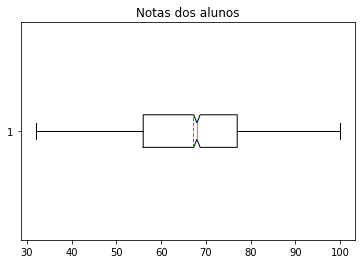

In [8]:
plt.title("Notas dos alunos")
plt.boxplot(f_data.posttest, vert = False, meanline = True, showcaps = True, showbox = True,
            showfliers = True, showmeans = True, notch = True)
plt.show()

Ao ver o boxplot da variável target, foi possível tirar algumas conclusões iniciais sobre o *target* com mais facilidade do que seria possível apenas com a descrição numérica. Por exemplo, é visível a distribuição populacional do *sample* conforme os quartis: há mais alunos com notas acima da média do que abaixo, o que condiz com a expectativa de que mais alunos passam de ano na escola do que não. 

Mais do que isso, há uma comparação entre a média (linha verde pontilhada) e a mediana (linha contínua laranja) dos dados. Os valores parecem similares numericamente mas há uma distância entre elas no boxplot que sugere que há uma concentração de alunos em torno da média dos dados, por mais que a metade superior dos dados apresente maior densidade.

In [9]:
def color_red(ax,n): #Colore parte do Histograma de vermelho
    for i in range(len(ax.patches)):
        if i < n:
            ax.patches[i].set_facecolor('r')

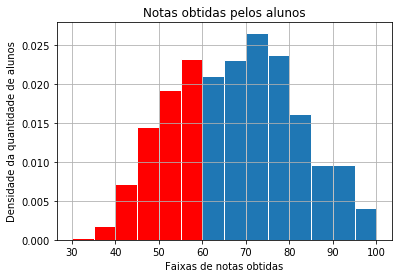

In [10]:
g_bins = range(30,101,5)
ax = f_data.posttest.hist(edgecolor = 'white',bins = g_bins, density = True)

color_red(ax,6)

plt.title('Notas obtidas pelos alunos')
plt.ylabel('Densidade da quantidade de alunos')
plt.xlabel('Faixas de notas obtidas')
plt.show()

Também foi feito um histograma, onde foram coloridas de vermelho as barras que representam notas abaixo da média (60), e de azul as notas que significariam uma aprovação no fim do ano.

Foi interessante fazer um boxplot e um histograma porque enquanto servem propósitos similares, eles dispõem a informação de maneiras que permitem diferentes conclusões a serem tiradas. O histograma diz onde fica a maior quantidade de alunos em um certo intervalo de notas - entre 70 e 75 pontos -, e permite avaliar como os dados estão distribuídos. O boxplot, no entanto, dá uma visualização mais geral do dataset, respondendo perguntas como: onde ficam os quartis em relação à média e a mediana? Elas são iguais? Como as notas estão distribuidas em relação à média e mediana?

### Variáveis Feature

Além de facilitar a visualização dos conteúdos das variáveis como foi feito com a variável *target*, também foi averiguado se existe alguma correlação entre elas, ou alguma outra variável que deveria ser retirada para evitar ruídos.

Primeiro, foram construídos histogramas com base nas categorias binárias das notas dos alunos, novamente marcando as notas abaixo da média em vermelho para facilitar a visualização.

In [11]:
binary_cols = [col for col in f_data.columns if str(f_data[col].dtype)=='category' and len(f_data[col].cat.categories)==2]
c = 1

print(binary_cols)

['school_type', 'teaching_method', 'gender', 'lunch']


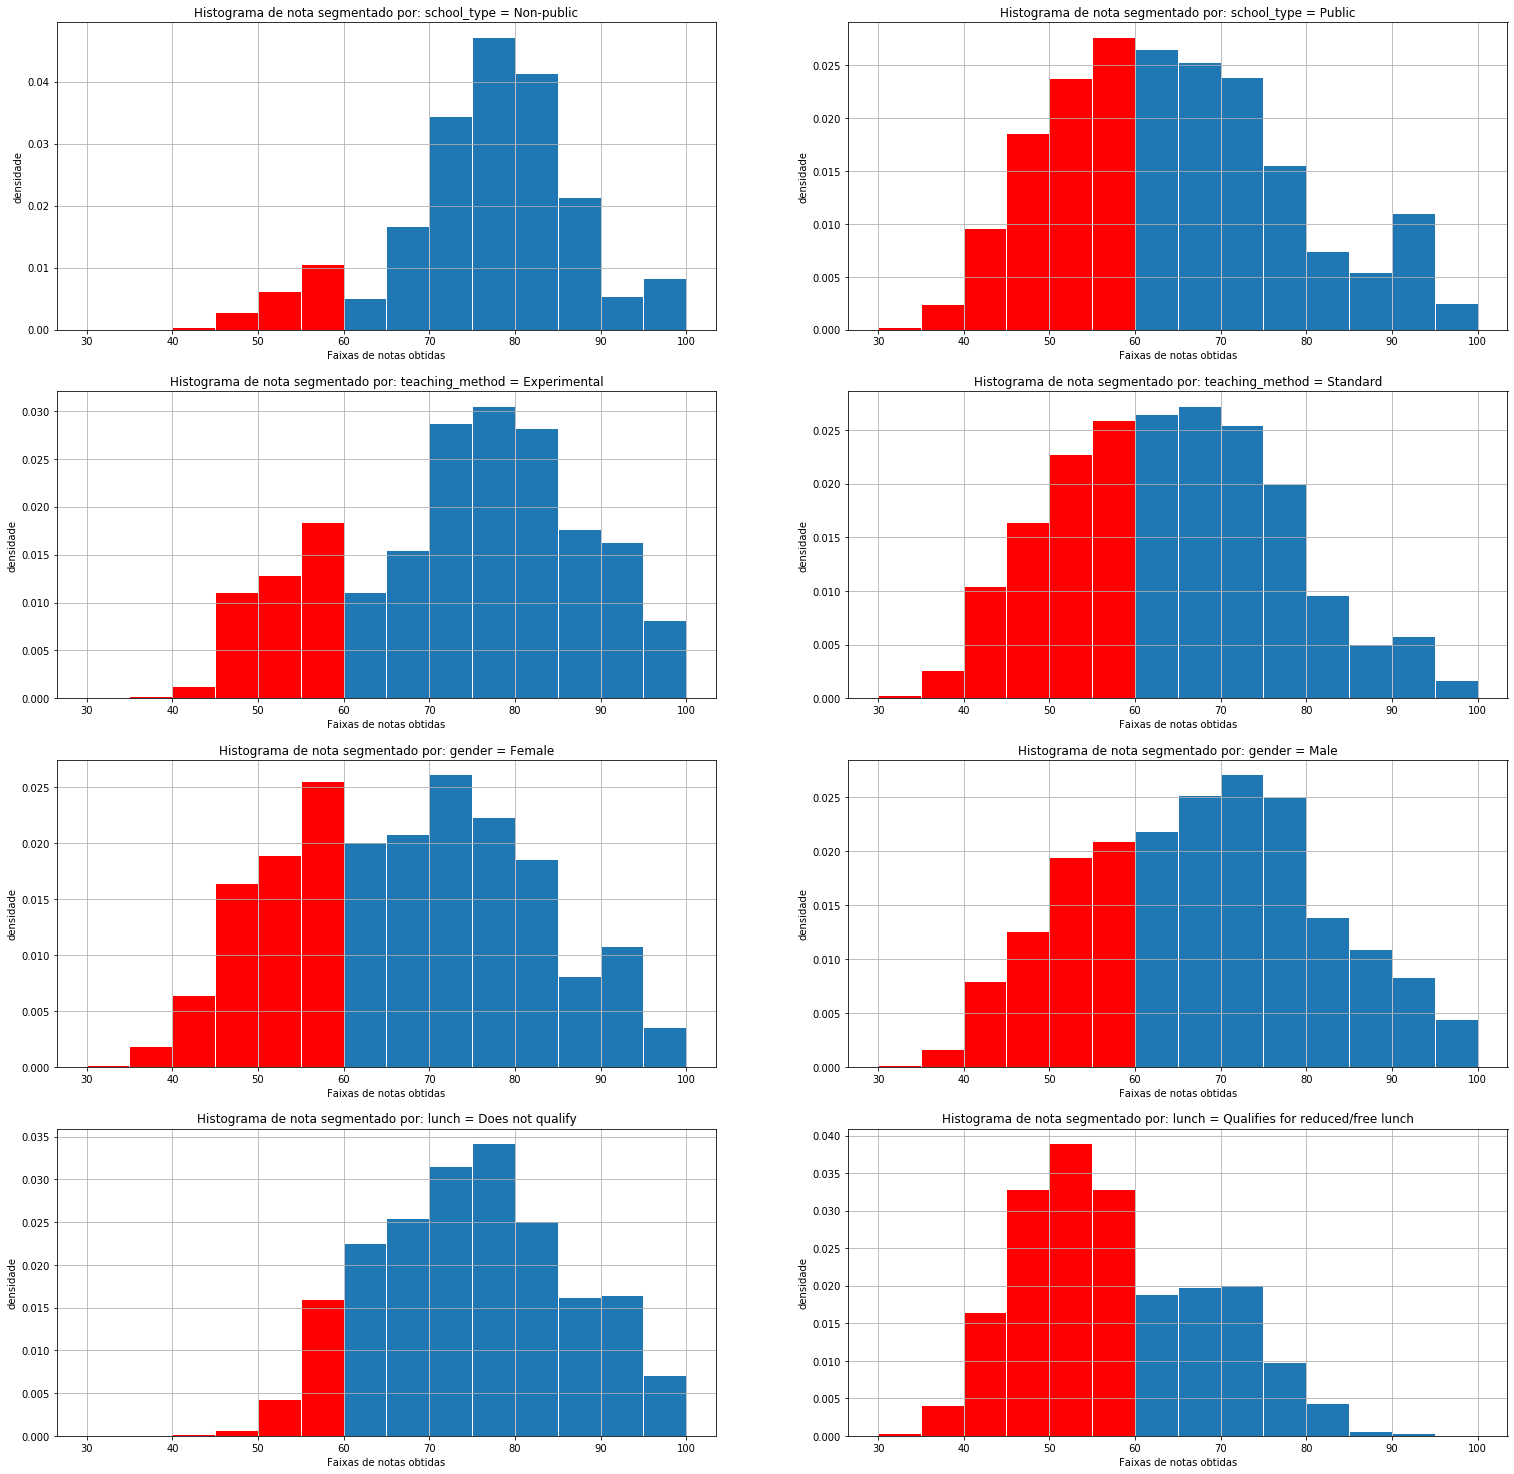

In [13]:
#Automaticamente gera histogrmas do target segmentados pelas variáveis binárias
plt.figure(figsize =(26,26))

for j, col in enumerate(binary_cols):
    cats = f_data[col].cat.categories
    for i in range(len(cats)):
        plt.subplot(len(binary_cols),2,c)
        plt.title(f'Histograma de nota segmentado por: {col} = {cats[i]}')
        plt.xlabel('Faixas de notas obtidas')
        plt.ylabel('densidade')
        ax = f_data.loc[f_data[col] == cats[i],'posttest'].hist(edgecolor = 'white',bins = g_bins,density = True)
        color_red(ax,6)
        c+=1
plt.show()

Analisando os histogramas é possível notar que a variável gênero parece não influenciar muito o target. A distribuição do target para ambos gêneros é simétrica e a densidade das faixas nas extremidades parece ser semelhante apesar de a densidade das faixas mais próximos da media ser um pouco diferente. Para se ter informações mais concretas pode-se fazer as medidas resumo adequadas.

In [12]:
df = f_data.groupby('gender').describe().posttest

styler = df.style.set_caption('Resumo Posttest Segmentado por Gênero').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '15px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

display(styler)

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1056.000000,67.004735,14.139018,32.000000,56.000000,68.000000,78.000000,100.000000
Male,1077.000000,67.197772,13.841807,34.000000,57.000000,68.000000,77.000000,100.000000


Analisando os valores acima, se nota que a média de notas para ambos gêneros é muito próxima, assim como o valor de todos quartis. Foi decidido remover a variável gender do modelo por não ver uma grande influência dela na nota final dos alunos.

In [13]:
f_data.drop(columns='gender',inplace=True)
features = list(filter(lambda x: x!= 'gender', features))

Alguns destes histogramas, comparando a distribuição entre os dois valores das variáveis binárias, ressaltam um grande impacto na nota dos alunos, como (por exemplo) se a escola é pública ou particular. Uma quantidade quase irrelevante dos estudantes de escola particular tiraram nota vermelha, enquanto uma quantidade extremamente significante dos alunos de escola pública fizeram o mesmo. Isso indica que o tipo de escola onde o aluno estuda é um forte influenciador na nota.

É possível identificar uma discrepância similar ao outro caso na variável sobre o programa de distribuição de merenda, o que sugere que não é o tipo de escola que influencia mais no resultado que os estudantes apresentam, e sim a renda familiar dos alunos. Se um estudante estuda em escola pública e qualifica para o programa, há uma chance muito maior de que ele tenha nota abaixo da média do que um estudante de escola privada que não qualifique para o programa.

Afim de tentar confirmar essa suspeita, tentou-se traçar um gráfico conclusivo abaixo.

In [12]:
schools = f_data.school_type.cat.categories
lunch = f_data.lunch.cat.categories
inters = [(schools[i], lunch[j]) for i in range(2) for j in range(2)]

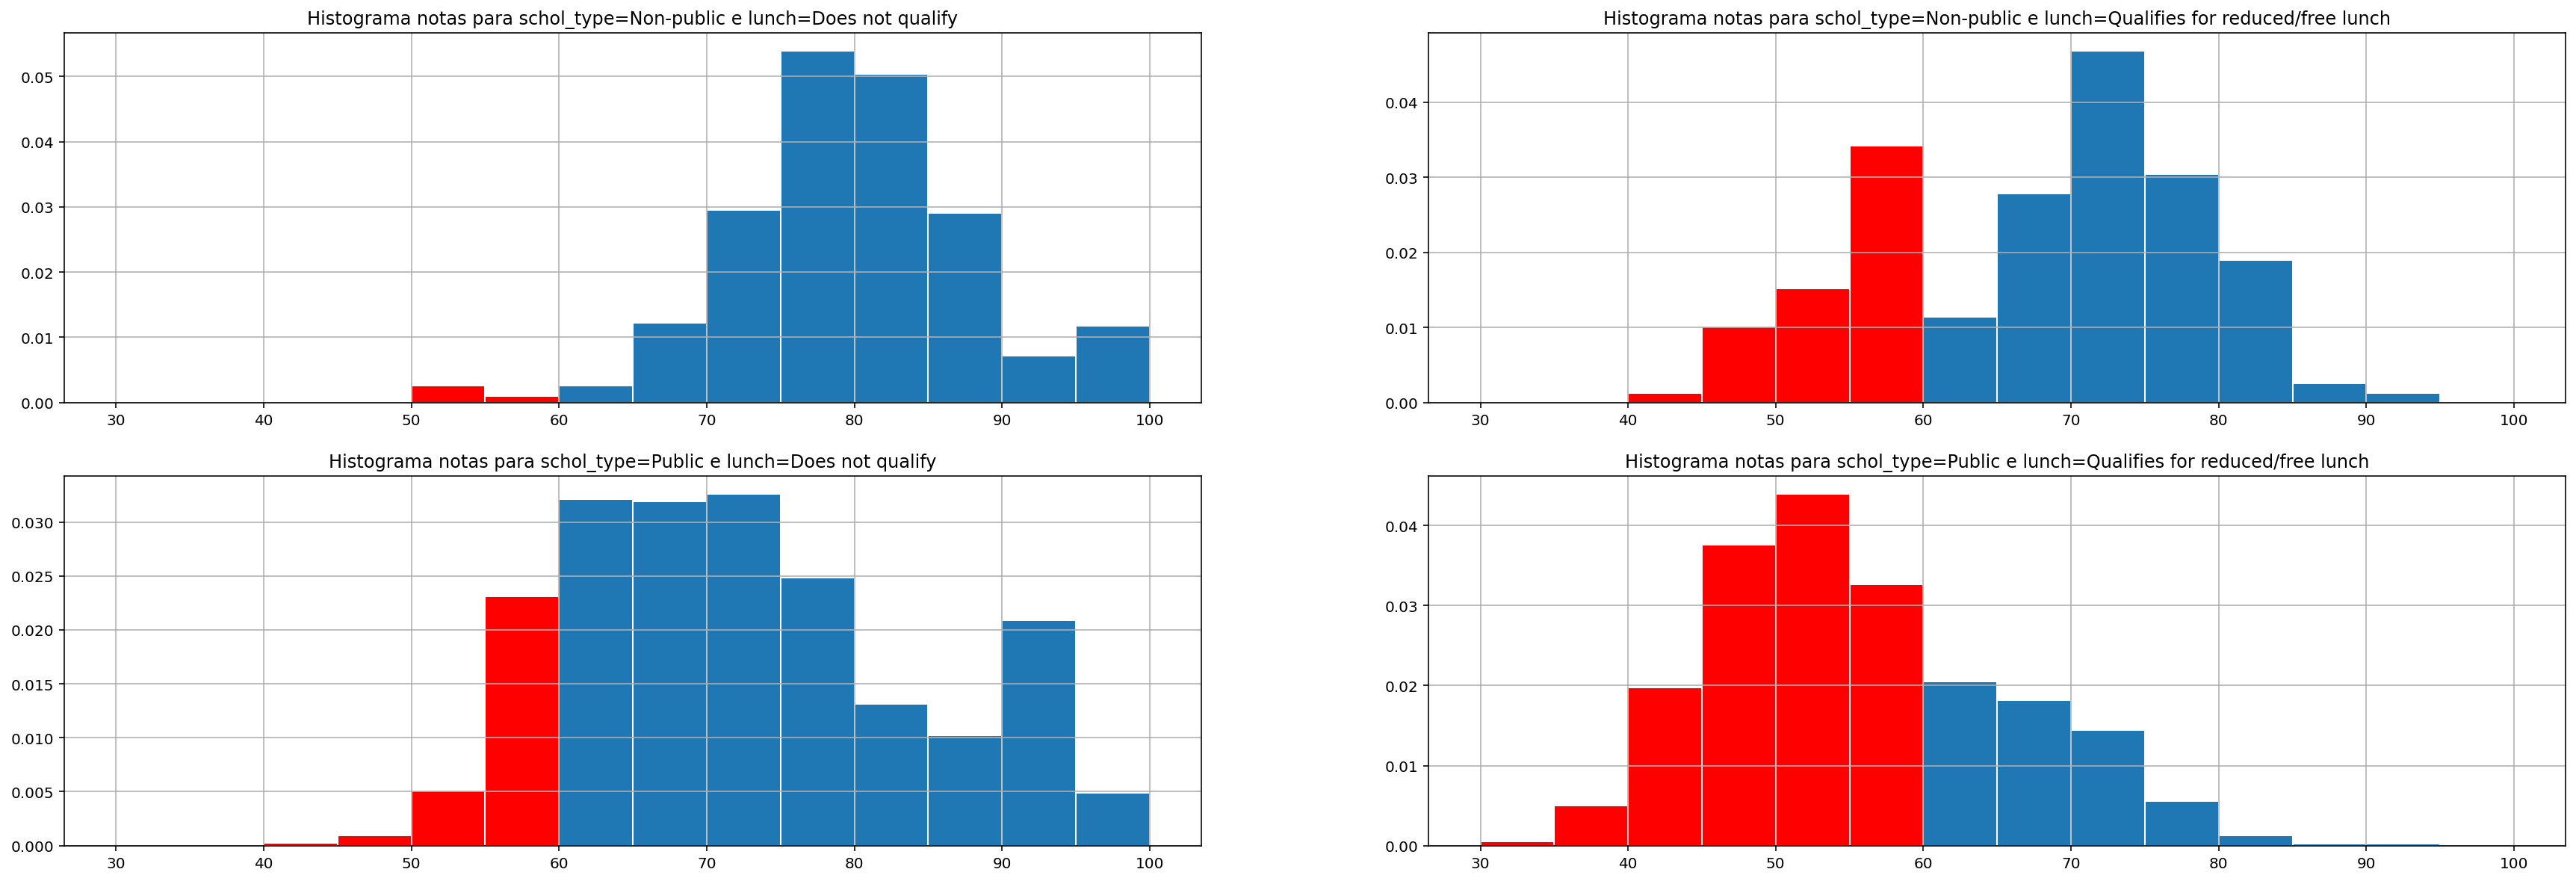

In [14]:
plt.figure(figsize=(30,10))
for i,inter in enumerate(inters):
    plt.subplot(221+i)
    plt.title(f'Histograma notas para schol_type={inter[0]} e lunch={inter[1]}')
    ax = f_data.loc[(f_data.school_type == inter[0]) & (f_data.lunch == inter[1]),"posttest"].hist(edgecolor = 'white',
                                                                                                   bins = g_bins,
                                                                                                   density = True)
    color_red(ax,6)
plt.show()

Olhando os gráficos acima, é possível ver que há sim mais alunos que qualifiquem para o programa de merenda grátis que tenham nota vermelha, tanto nas escolas públicas quanto nas privadas.

Em comparação, os alunos que tiraram notas azuis são muito menos padronizados entre as quatro categorias plotadas acima. Na sua maioria, as notas dos alunos de escola privada que não tiraram nota vermelha tendem a circular entre 75 e 85 pontos se não qualificam para o programa, e 70-75 se qualificam. Já nas escolas públicas, não existe um padrão identificável fora dizer que a maioria dos alunos que qualificam para o programa de merenda grátis representam a maioria das notas vermelhas das escolas. 

Para tentar investigar um pouco mais sobre a possibilidade, foi construido um crosstab entre os estudantes de cada tipo de escola e quem qualifica para o programa de merenda grátis, e foi concluido que não se pode afirmar que qualificar ou não para o programa seja indicativo de notas mais ou menos altas. A maioria dos estudantes que qualificam para o programa se encontra em escolas públicas e é possível que seja este o fator determinante das notas, onde qualificar ou não para o programa seja menos relevante do que o tipo de escola onde estudam.

In [15]:
pd.crosstab(f_data.school_type,f_data.lunch,normalize='columns').round(3)*100

lunch,Does not qualify,Qualifies for reduced/free lunch
school_type,,
Non-public,32.3,17.2
Public,67.7,82.8


Foi decido também explorar a possibilidade da renda ser um fator determinante forte das notas dos alunos, mas como não foi possível encontrar os requerimentos para qualificar para o programa de merenda grátis, não se pode afirmar que seja este o caso com certeza.

Seria desejável entrar em mais detalhe nesta parte da análise exploratória em uma futura iteração do modelo onde houvesse mais informação sobre o programa de merenda grátis e a demografia das escolas públicas e particulares, porém para esta iteração o grupo está satisfeito em dizer que há forte indicação de que um dos fatores principais na nota dos alunos é realmente a renda.

Para as variáveis categóricas e numéricas foi decidido usar crosstabs pois fazer histogramas segmentados resultaria em muita poluição visual, atrapalhando o entendimento. Foi usado o mesmo intervalo de 5 pontos para *target* como foi usado nos histogramas anteriores.

In [16]:
binned_grades = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(binned_grades,f_data.school_setting,normalize="columns")*100).round(1)

school_setting,Rural,Suburban,Urban
posttest,,,
"(30, 35]",0.0,0.0,0.3
"(35, 40]",3.1,0.0,1.2
"(40, 45]",8.0,0.0,5.8
"(45, 50]",3.9,0.6,15.5
"(50, 55]",9.2,2.5,16.9
"(55, 60]",15.1,6.0,13.7
"(60, 65]",8.0,9.1,12.3
"(65, 70]",15.5,14.6,9.6
"(70, 75]",18.8,16.2,6.1


In [17]:
(pd.crosstab(binned_grades,pd.cut(f_data.n_student,bins=range(10,36,5)),normalize="columns")*100).round(1)

n_student,"(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]"
posttest,,,,,
"(30, 35]",0.0,0.0,0.0,0.5,0.0
"(35, 40]",0.0,0.0,2.1,1.4,0.0
"(40, 45]",0.0,0.0,7.0,5.5,0.0
"(45, 50]",0.0,1.1,7.8,15.7,0.0
"(50, 55]",0.0,5.7,8.5,17.1,41.9
"(55, 60]",0.0,8.8,9.2,16.9,51.6
"(60, 65]",1.4,5.7,7.6,20.1,6.5
"(65, 70]",16.4,10.3,15.1,11.6,0.0
"(70, 75]",26.0,20.0,11.1,6.2,0.0


## Preparação para Modelar
Na célula abaixo, as variáveis antes vistas como categóricas e binárias foram alteradas para valores que sejam utilizáveis pelos modelos, mantendo as variáveis numéricas. Variáveis binárias foram convertidas para ter 1 e -1 como possíveis valores, enquanto as categóricas foram convertidas para terem os valores 1, 2, 3, ..., n onde n é o número de categorias.

In [18]:
#Automaticamente transforma variáveis categóricas e binárias em valores que podem ser usados pelo modelo
data = f_data.copy()
categories = dict()

for col in data.columns:
    if str(data[col].dtype) != "category": #Series numericas nao sao alteradas
        continue
    if len(cats := data[col].cat.categories) == 2:
        #Series com 2 categorias viram -1 e 1
        #(de acordo com recomendação para variáveis binárias da documentação do sklearn)
        categories[col] = {cats[0]:-1,cats[1]:1}
    else:
        #Series com número de categorias = n e n>2 viram 1, 2, 3, ..., n
        #(também de acordo com documentação)
        categories[col] = {cats[i]:i for i in range(len(cats))}
    data[col] = data[col].apply(lambda x: categories[col][x])

print(categories)
data.head()

{'school_setting': {'Rural': 0, 'Suburban': 1, 'Urban': 2}, 'school_type': {'Non-public': -1, 'Public': 1}, 'teaching_method': {'Experimental': -1, 'Standard': 1}, 'lunch': {'Does not qualify': -1, 'Qualifies for reduced/free lunch': 1}}


,school_setting,school_type,teaching_method,n_student,lunch,pretest,posttest
0,2,-1,1,20.0,-1,62.0,72.0
1,2,-1,1,20.0,-1,66.0,79.0
2,2,-1,1,20.0,-1,64.0,76.0
3,2,-1,1,20.0,-1,61.0,77.0
4,2,-1,1,20.0,-1,64.0,76.0


## Aplicando Modelos de Tomada de Decisão
                                        
A partir da análise exploratória feita, foi obtida uma ideia muito mais consolidada dos fatores que podem influenciar a nota dos alunos, então foi iniciado o teste de alguns modelos de predição. Para isso foram escolhidos para este projeto os modelos Decision Tree e Random Forest.

### Decision Tree
O primeiro modelo que foi escolhido é o modelo de Decision Tree, que foi usado para fazer uma regressão. Ele é um dos modelos de *machine learning* mais usados por ser simples de entender, e não depender dos dados serem lineares ou não para funcionar, além de ter a possibilidade de ser ambos um regressor como foi empregado neste projeto ou um classificador. Por permitir o uso de um dataset misto com variáveis categóricas e numéricas para fazer uma regressão, foi escolhido como o primeiro modelo do projeto.

O modelo funciona por meio de tomadas de decisão a partir dos dados de teste, fazendo splits nos dados para tentar aumentar a pureza deles em relação à variável target. Começando a partir da *root* da árvore, o modelo vai gerando mais e mais *branches* fazendo uma série de perguntas de resposta Verdadeiro ou Falso para afunilar os valores possíveis de predição até que se encontre o melhor.

### Random Forest
Assim como o modelo Decision Tree, o segundo modelo escolhido - Random Forest - também é um modelo de *machine learning* bastante popular, e pelos mesmos motivos: usá-lo significa muita simplicidade em gerar um resultado razoável ou bom, podendo usar um dataset com variáveis mistas entre categóricas e numéricas, e ainda sendo um regressor ou mesmo um classificador. O motivo pela semelhança entre os dois modelos é que Random Forest é uma série de Decision Trees treinadas usando uma técnica chamada *bagging*. *Bagging* estima predições com base na árvore atual do modelo para gerar outra de maneira que se aumente a pureza da predição quanto à variável target, tornando o modelo Random Forest virtualmente um modelo de Decision Tree mais treinado.

In [19]:
# Separa o df em train e test, com teste de 1/3
train, test =(data.iloc[:1400].copy(), data.iloc[1400:].copy())

tree = DecisionTreeRegressor()
forest = RandomForestRegressor()

tree.fit(train.drop(columns=["posttest"]),train.posttest)
forest.fit(train.drop(columns=["posttest"]),train.posttest)

test["prediction_tree"] = tree.predict(test.drop(columns=["posttest"]))
test["prediction_forest"] = forest.predict(test.drop(columns=["posttest","prediction_tree"]))

test.head()

,school_setting,school_type,teaching_method,n_student,lunch,pretest,posttest,prediction_tree,prediction_forest
1400,1,1,1,22.0,-1,63.0,75.0,69.0,69.369667
1401,1,1,1,22.0,-1,59.0,70.0,67.0,67.490190
1402,1,1,1,22.0,-1,64.0,70.0,68.0,69.473333
1403,1,1,1,22.0,-1,64.0,69.0,68.0,69.473333
1404,1,1,1,22.0,-1,60.0,70.0,69.0,68.578500


## Testando a performance dos modelos

Após o treinamento dos modelos e predições aplicadas ao dataset de teste, é necessário também fazer comparativos e análises de eficiência, com o objetivo de averiguar a eficácia do modelo e se eles realmente foram escolhas adequadas.

Como um primeiro teste, foi feito um scatterplot para cada modelo com os dados reais no eixo x e os previstos no eixo y, conforme pode ser visto abaixo. A reta F(x)=x também foi adicionada, representando onde os pontos estariam posicionados caso o modelo fosse 100% preciso em usas predições.

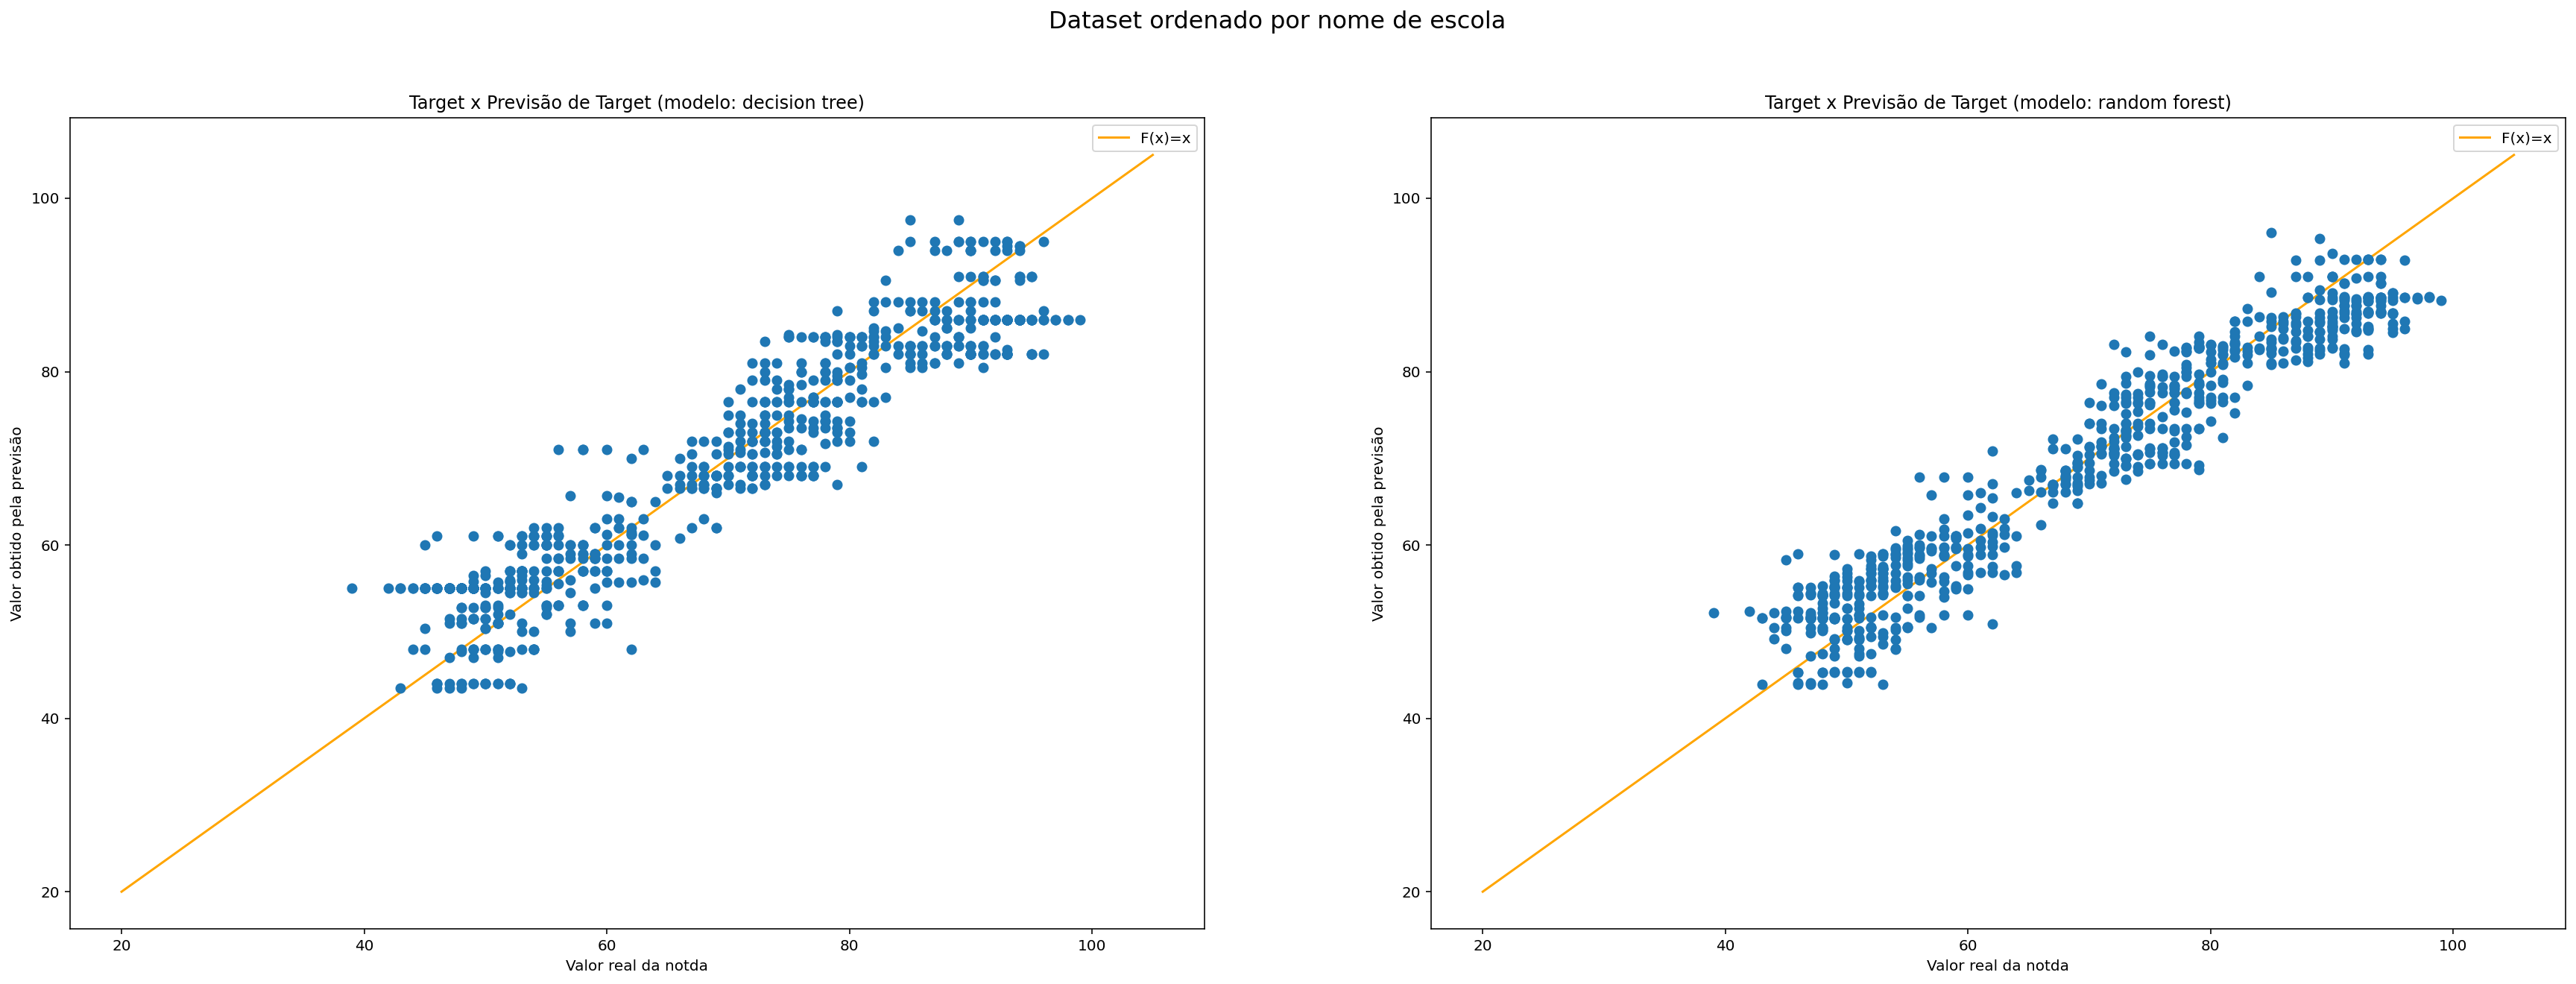

In [20]:
fig = plt.figure(figsize=(30,10))

for title,col,i in zip(["(Modelo: Decision Tree)","(Modelo: Random Forest)"],[test.prediction_tree,test.prediction_forest],range(2)):
    plt.subplot(121+i)
    plt.title(f'Target x Previsão de Target {title}')
    plt.xlabel('Valor real da notda')
    plt.ylabel('Valor obtido pela previsão')
    plt.plot([20,105],[20,105],label='F(x)=x',color='orange',zorder=1)
    plt.scatter(test.posttest,col,zorder=2)
    plt.legend()
fig.suptitle('Dataset ordenado por nome de escola', fontsize=16)

plt.show()

O plot feito acima revela boa proximidade dos pontos com a reta, o que sugere uma boa correlação entre os dados reais e as predições.

Com o objetivo de determinar o quão eficiente o modelo realmente é, foi utilizada a função `.score()`, que mostra o coeficiente de determinação (R²) do teste, cujo valor máximo é 1 e mostra a correlação entre o teste e os valores reais, sendo o valor 1 o mais correlacionado possível.

In [21]:
print(f'score tree: {tree.score(test.loc[:,features],test.loc[:,target])}')
print(f'score forest: {forest.score(test.loc[:,features],test.loc[:,target])}')

score tree: 0.8833508320150983
score forest: 0.9209015294512661


Abaixo também foi calculado o RMSE (*Root Mean Square Error*, em inglês) de cada modelo com o objetivo de analisar o valor da incerteza relacionada aos resultados, levando em conta seus erros.

In [22]:
print(f'RMSE forest: {mean_squared_error(test.loc[:,target],test.loc[:,"prediction_tree"],squared=False)}')
print(f'RMSE forest: {mean_squared_error(test.loc[:,target],test.loc[:,"prediction_forest"],squared=False)}')

RMSE forest: 5.438748427959739
RMSE forest: 4.478599126435577


Foi hipotetizado que a ordem na qual o modelo foi divido poderia estar afetando os resulatdos, agrupando todos os alunos de uma única escola e assim inviesando a predição com base nas escolas. Para averiguar se estavam ordenados, foi feito um print da coluna da indentificação da escola do dataset original antes de remover esta variável.

In [23]:
print(raw_data.school.to_list()[:200])

['ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 

Confirmado que os dados estão ordenados por noome de escola, foi chegada à conclusão de que a divisão entre teste e treinamento foi realizada de maneira que invezasse o modelo ao deixar alunos da mesma escola ou só no treinamento ou só no teste, afetando a performance negativamente. Por isso, foi decidido por refazer a divisão entre o treinamento e o teste, porém embaralhando as linhas do dataset de maneira que separassem os alunos de cada escola.

In [24]:
r_data = data.sample(frac=1, random_state=13077, ignore_index=True)

# Separa o df em train e test, com teste de 1/3
r_train, r_test =(r_data.iloc[:1400].copy(), r_data.iloc[1400:].copy())

r_tree = DecisionTreeRegressor()
r_forest = RandomForestRegressor()

r_tree.fit(r_train.loc[:,features],r_train.posttest)
r_forest.fit(r_train.loc[:,features],r_train.posttest)

r_test["prediction_tree"] = r_tree.predict(r_test.loc[:,features])
r_test["prediction_forest"] = r_forest.predict(r_test.loc[:,features])

r_test.head()

,school_setting,school_type,teaching_method,n_student,lunch,pretest,posttest,prediction_tree,prediction_forest
1400,0,-1,-1,18.0,1,63.0,84.0,76.000000,78.142810
1401,0,1,1,22.0,1,30.0,42.0,40.333333,40.267706
1402,1,1,-1,23.0,-1,75.0,94.0,91.000000,90.983095
1403,0,1,1,22.0,1,42.0,56.0,53.500000,53.222889
1404,1,-1,1,21.0,-1,76.0,85.0,80.000000,81.240000


## Testando a performance dos modelos

Os testes de eficiência realizados usaram os modelos embaralhados, começando com a re-plotagem dos scatterplots feitos anteriormente:

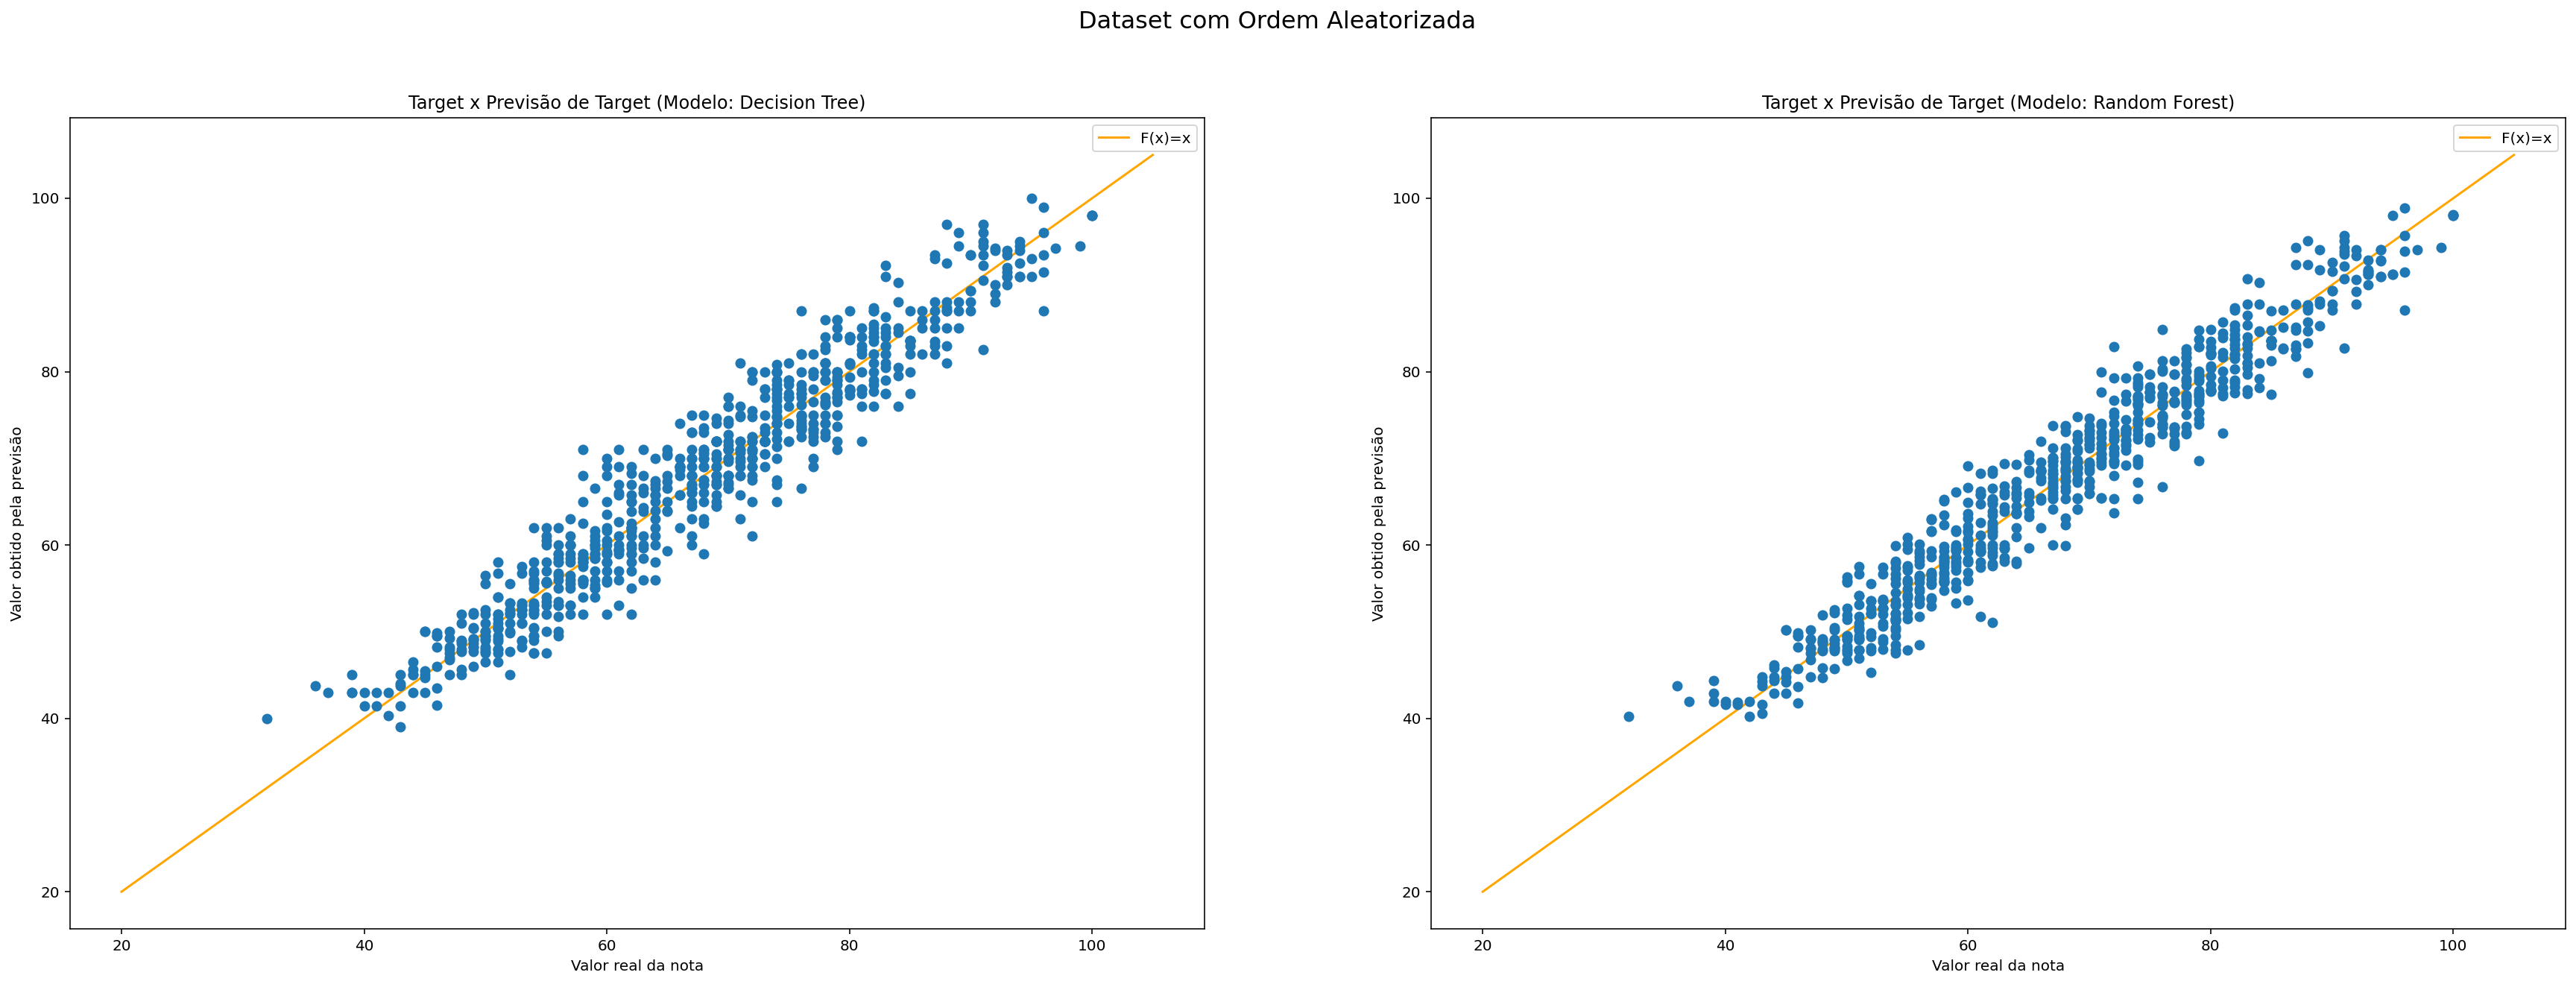

In [25]:
fig = plt.figure(figsize=(30,10))

for title,col,i in zip(["(Modelo: Decision Tree)","(Modelo: Random Forest)"],[r_test.prediction_tree,r_test.prediction_forest],range(2)):
    plt.subplot(121+i)
    plt.title(f'Target x Previsão de Target {title}')
    plt.xlabel('Valor real da nota')
    plt.ylabel('Valor obtido pela previsão')
    plt.plot([20,105],[20,105],label='F(x)=x',color='orange',zorder=1)
    plt.scatter(r_test.posttest,col,zorder=2)
    plt.legend()
fig.suptitle('Dataset com Ordem Aleatorizada', fontsize=16)

plt.show()

Através deste plot parece ser possível concluir que embaralhar as linhas do dataset melhora consideravelmente a sua eficácia, que será visualizada numericamente nas próximas células.

## Obtendo o valor de R² para a previsão obtida
### R² do Decision Tree
Extraindo o R² da predição por Decision Tree embaralhada:

In [26]:
r_tree.score(test.loc[:,features],test.loc[:,target])

0.9730914797535266

### R² do Random Forest
Extraindo o R² da predição por Random Forest embaralhada:

In [27]:
r_forest.score(test.loc[:,features],test.loc[:,target])

0.9752533999829542

Extraindo o RMSE de ambos as predições dos modelos embaralhados:

In [28]:
print(f'RMSE forest: {mean_squared_error(r_test.loc[:,target],r_test.loc[:,"prediction_tree"],squared=False)}')
print(f'RMSE forest: {mean_squared_error(r_test.loc[:,target],r_test.loc[:,"prediction_forest"],squared=False)}')

RMSE forest: 3.695631200904869
RMSE forest: 3.278949956316996


Foi possível verificar uma clara melhora em relação ao modelos anteriores pois o coeficiente de determinação (R²) aumentou e o erro médio diminuiu. Em seguida foi feita a validação cruzada para melhor validar os modelos.

## Validação Cruzada
A validação cruzada consiste em redividir o dataset em subsets de treino e teste várias vezes, e verificar a performance do modelo treinado com essas diferentes iterações. Neste projeto, ela foi feita com a estratégia KFold, que consiste em dividir o dataset em n pedaços e realizar n iterações do modelo. A cada iteração, um dos pedaços será usado como teste e os outros combinados serão usados como treino. Foram feitas 10 iterações de cada modelo, ou seja, n=10.

### Predição com Decision Tree

In [50]:
crss_val_tree = pd.DataFrame(cross_validate(r_tree,r_data.loc[:,features],r_data.loc[:,target],
                                            scoring=['r2','neg_root_mean_squared_error'],cv=KFold(n_splits=10)))
crss_val_tree

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error
0,0.009910,0.003500,0.917760,-3.988760
1,0.053950,0.004088,0.943204,-3.584204
2,0.007102,0.002941,0.931234,-3.569979
3,0.006667,0.002842,0.914180,-3.931904
4,0.092183,0.004338,0.932791,-3.794465
5,0.098198,0.003353,0.930393,-3.831628
6,0.093064,0.003631,0.937414,-3.628062
7,0.006441,0.089731,0.933080,-3.628414
8,0.100728,0.003342,0.934580,-3.372881
9,0.010158,0.003723,0.923884,-3.482061


#### Obtendo valores de R² e RMSE médios
Com base nos resultados da validação cruzada foi plotada também uma tabela que contém o desvio padrão e a média dos resultados do R² e da média dos erros quadrados, com objetivo de analisar a performance média esperada do modelo de previsão.

In [51]:
crss_val_tree.loc[:,["test_r2","test_neg_root_mean_squared_error"]].describe().loc[["std","mean"]].rename(
    columns={"test_r2":"R²","test_neg_root_mean_squared_error":"RMSE"})

,R²,RMSE
std,0.008860,0.198609
mean,0.929852,-3.681236


### Predição com Random Forest

In [42]:
crss_val_forest = pd.DataFrame(cross_validate(r_forest,r_data.loc[:,features],r_data.loc[:,target],
                                              scoring=['r2','neg_root_mean_squared_error'],cv=KFold(n_splits=10)))
crss_val_forest

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error
0,0.799934,0.091956,0.930533,-3.665932
1,0.630758,0.065902,0.956052,-3.152827
2,0.718607,0.023263,0.948665,-3.084493
3,0.669804,0.031220,0.931669,-3.508475
4,0.673206,0.022195,0.954084,-3.136308
5,0.831240,0.035117,0.945696,-3.384316
6,0.706852,0.021019,0.945740,-3.378126
7,0.585565,0.020360,0.951142,-3.100300
8,0.582927,0.012809,0.939181,-3.252119
9,0.571648,0.012583,0.938208,-3.137358


#### Obtendo valores de R² e RMSE médios

In [43]:
crss_val_forest.loc[:,["test_r2","test_neg_root_mean_squared_error"]].describe().loc[["std","mean"]].rename(
    columns={"test_r2":"R²","test_neg_root_mean_squared_error":"RMSE"})

,R²,RMSE
std,0.008918,0.197235
mean,0.944097,-3.280025


Analisando os resultados, os modelos preveem com boa precisão a nota final dos alunos. Tanto o R² quanto o RMSE da predição com Decision Tree apontam que o modelo é ligeiramente menos preciso do que a feita com Random Forest. Isso era um resultado esperado, visto que o modelo Random Forest funciona de maneira muito parecida com o Decision Tree, como foi explicado anteriormente. 

A diferença de performance é muito pequena analisando apenas a primeira iteração dos modelos, mas ao analisar a validação cruzada é possível ver que essa performance maior do Random Forest é consistente nas 10 iterações do modelo, visto que o R² permanece consistentemente maior que o do Decision Tree e o RSME menor que o do Decision Tree também.

## Conclusão

Para melhor responder a pergunta a respeito da influencia do ambiente de ensino nas notas, foi decidido testar se o modelo também funcionaria de maneira razoável sem o uso da *feature* `pretest`, que representa a nota do aluno antes a prova final. Ao utilizar apenas informações sobre o contexto escolar, é possível estimar qual o impacto que o ambiente escolar tem sobre o desempenho dos estudantes de forma que permita aceitar ou rejeitar a hipótese original de que o ambiente escolar tem forte influência nas notas obtidas pelos estudantes.

Nas células abaixo foram repetidos os processos de treinamento e validação como feito para os modelos anteriores, retirando a *feature* `pretest`.

In [33]:
data2 = r_data.drop(columns="pretest")

# Separa o df em train e test, com teste de 1/3
train2, test2 =(data2.iloc[:1400].copy(), data2.iloc[1400:].copy())

tree2 = DecisionTreeRegressor()
forest2 = RandomForestRegressor()

tree2.fit(train2.drop(columns=["posttest"]),train2.posttest)
forest2.fit(train2.drop(columns=["posttest"]),train2.posttest)

test2["prediction_tree"] = tree2.predict(test2.drop(columns=["posttest"]))
test2["prediction_forest"] = forest2.predict(test2.drop(columns=["posttest","prediction_tree"]))

test2.head()

,school_setting,school_type,teaching_method,n_student,lunch,posttest,prediction_tree,prediction_forest
1400,0,-1,-1,18.0,1,84.0,82.000000,81.851982
1401,0,1,1,22.0,1,42.0,48.382353,48.768334
1402,1,1,-1,23.0,-1,94.0,90.000000,89.937758
1403,0,1,1,22.0,1,56.0,48.382353,48.768334
1404,1,-1,1,21.0,-1,85.0,83.333333,83.721915


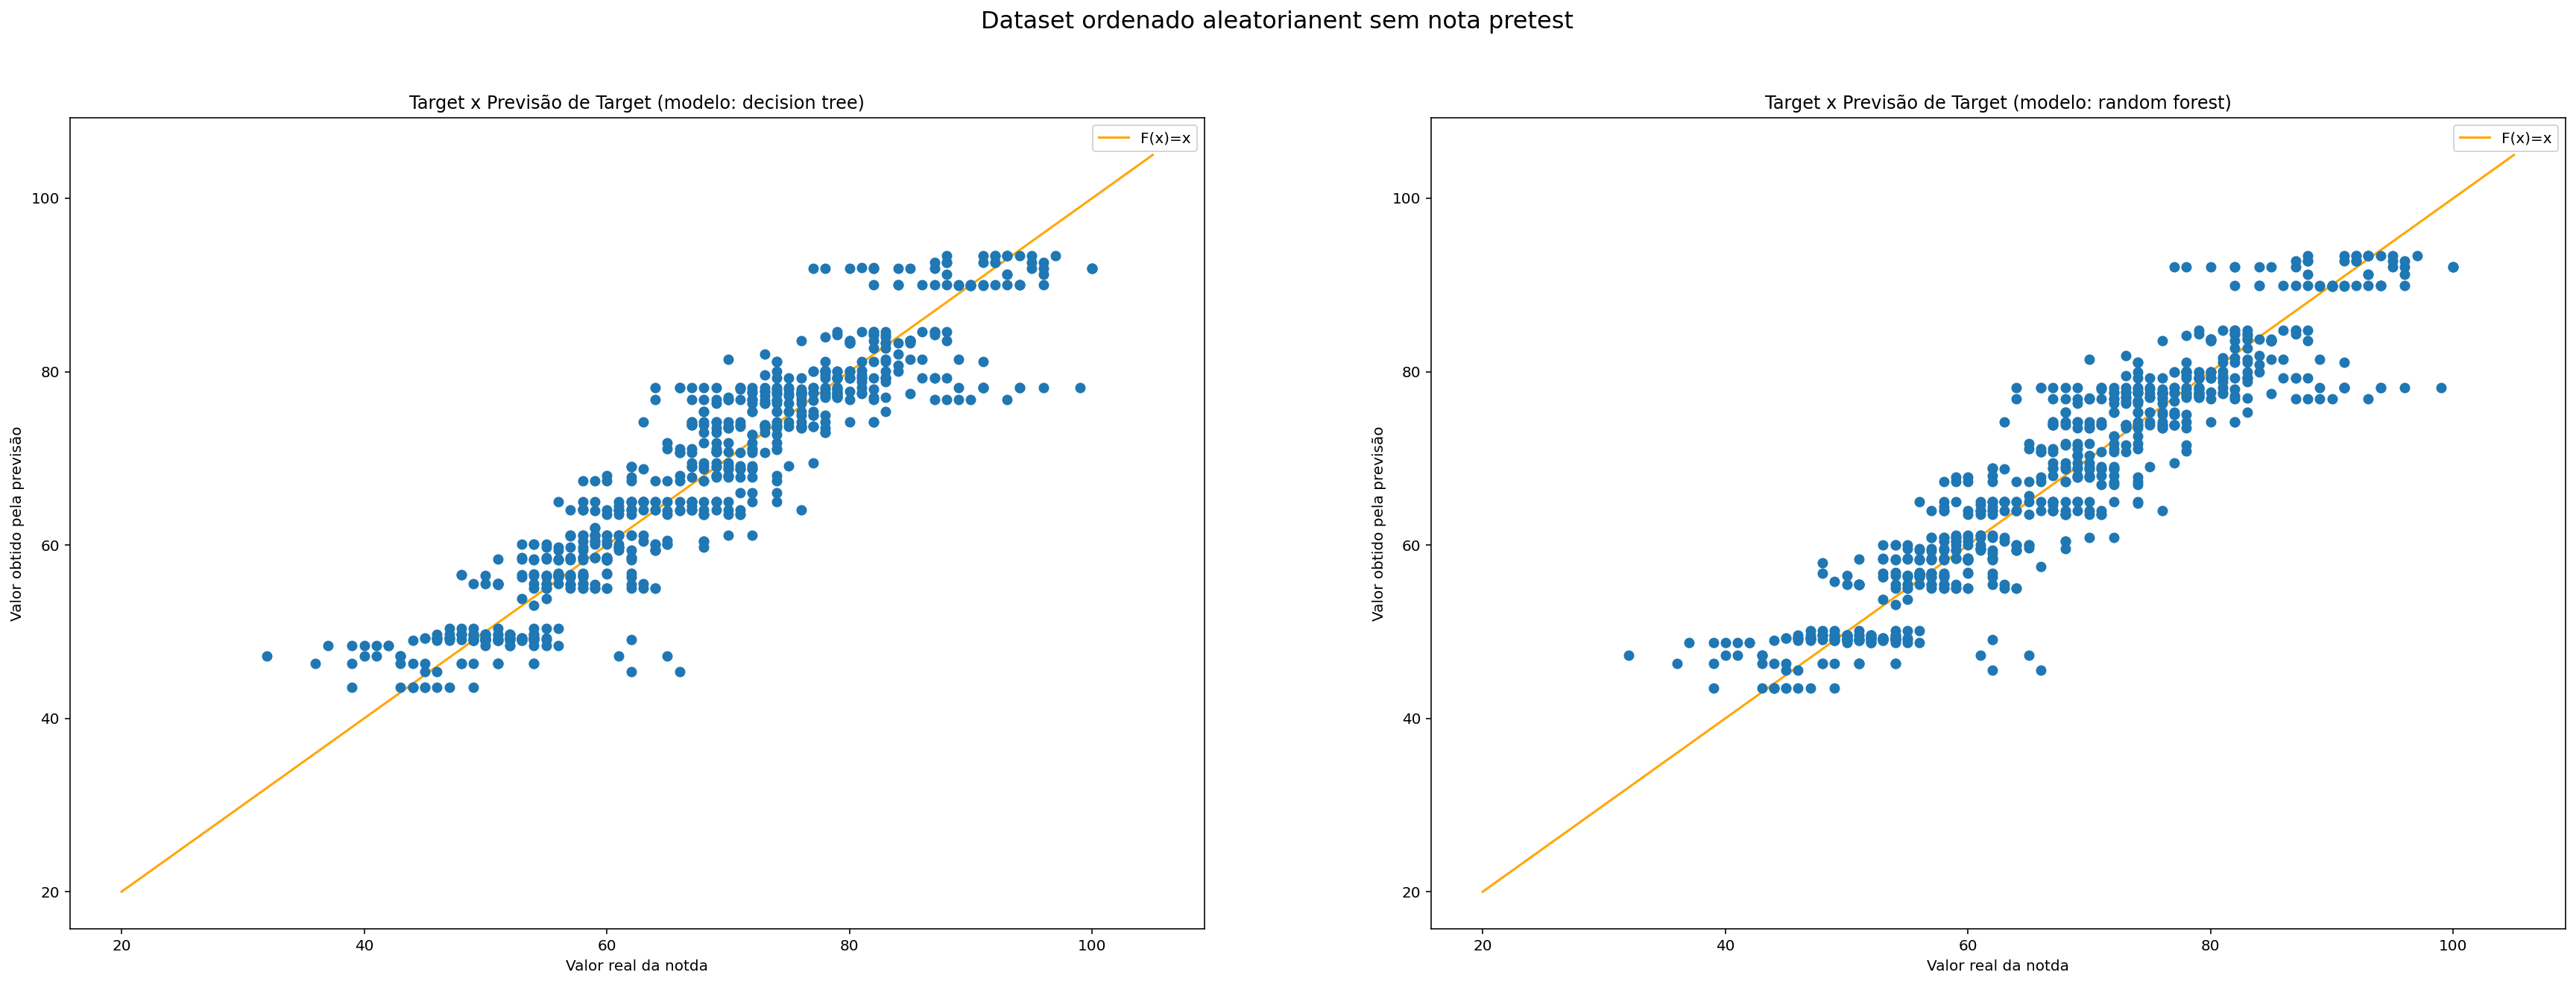

In [34]:
fig = plt.figure(figsize=(30,10))

for title,col,i in zip(["(modelo: decision tree)","(modelo: random forest)"],
                       [test2.prediction_tree,test2.prediction_forest],range(2)):
    plt.subplot(121+i)
    plt.title(f'Target x Previsão de Target {title}')
    plt.xlabel('Valor real da notda')
    plt.ylabel('Valor obtido pela previsão')
    plt.plot([20,105],[20,105],label='F(x)=x',color='orange',zorder=1)
    plt.scatter(test2.posttest,col,zorder=2)
    plt.legend()
fig.suptitle('Dataset ordenado aleatorianent sem nota pretest', fontsize=16)

plt.show()

In [35]:
features2 = list(filter(lambda x: x!='pretest',features))

print(f'Score Decision Tree: {tree2.score(test2.loc[:,features2],test2.loc[:,target])}')
print(f'Score Random Forest: {forest2.score(test2.loc[:,features2],test2.loc[:,target])}')
print(f'RMSE Decision Tree: {mean_squared_error(test2.loc[:,target],test2.loc[:,"prediction_tree"],squared=False)}')
print(f'RMSE Random Forest: {mean_squared_error(test2.loc[:,target],test2.loc[:,"prediction_forest"],squared=False)}')

score tree: 0.8694048086119398
score tree: 0.8695366947388595
RMSE forest: 4.872750473974642
RMSE forest: 4.870289393620921


In [36]:
crss_val_tree = pd.DataFrame(cross_validate(tree2,data2.loc[:,features2],data2.loc[:,target],
                                            scoring=['r2','neg_root_mean_squared_error'],cv=KFold(n_splits=10)))
crss_val_tree.loc[:,["test_r2","test_neg_root_mean_squared_error"]].describe().loc[["std","mean"]].rename(
    columns={"test_r2":"R²","test_neg_root_mean_squared_error":"RMSE"}).style.set_caption(
    "Coeficientes Médios por Decision Tree")

,R²,RMSE
std,0.017605,0.467359
mean,0.862335,-5.168351


In [37]:
crss_val_forest = pd.DataFrame(cross_validate(forest2,data2.loc[:,features2],data2.loc[:,target],
                                              scoring=['r2','neg_root_mean_squared_error'],cv=KFold(n_splits=10)))
crss_val_forest.loc[:,["test_r2","test_neg_root_mean_squared_error"]].describe().loc[["std","mean"]].rename(
    columns={"test_r2":"R²","test_neg_root_mean_squared_error":"RMSE"}).style.set_caption(
    "Coeficientes Médios por Random Forest")

,R²,RMSE
std,0.016786,0.454325
mean,0.864076,-5.136111


Através das análises realizadas ao longo do projeto e das múltiplas tentativas de prever a nota final dos alunos, foi possível prever, com relativa precisão, a nota final do aluno mesmo retirando do modelo qualquer informação sobre notas anteriores com um erro médio de ±5.13257 pontos, o que corresponde a um valor baixo em relação à escala de 0 a 100. Uma hipótese a ser testada neste relatório era que o ambiente escolar apresenta de fato uma forte influência no desempenho escolar dos alunos, o que é sugerido pelas regressões feitas.

Em futuras iterações do modelo, seria interessante encontrar um dataset que tivesse informação de alunos globalmente, e não só de um país. É possível que o sistema de ensino de algum país seja mais dependente do ambiente do que outros, e ao analisar apenas um país, não é possível quantificar este potencial viés para confirmar ou rejeitar a hipótese. Ademais, testar modelos diferentes também seria uma melhoria a fazer para uma futura iteração, visto que foram empregados dois modelos similares e obtidos resultados similares entre si.

## Dataset no Kaggle
* https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students

## Referências Bibliográficas
* https://gdcoder.com/decision-tree-regressor-explained-in-depth/
* https://www.kdnuggets.com/2020/01/decision-tree-algorithm-explained.html
* https://towardsdatascience.com/a-dive-into-decision-trees-a128923c9298
* https://builtin.com/data-science/random-forest-algorithm
* https://builtin.com/data-science/tour-top-10-algorithms-machine-learning-newbies
* https://towardsdatascience.com/understanding-random-forest-58381e0602d2
* https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/
* https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b
* https://scikit-learn.org/stable/modules/cross_validation.html